In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



100%|██████████| 26.4M/26.4M [00:01<00:00, 20.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<?, ?B/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 14.2MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.51MB/s]


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.3)  
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 7 * 7)            
        x = F.relu(self.fc1(x))               
        x = self.dropout(x)                 
        x = self.fc2(x)                      
        return x



In [8]:
model=CNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
for epoch in range(10):  
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 529.5607
Epoch 2, Loss: 349.6411
Epoch 3, Loss: 303.9278
Epoch 4, Loss: 276.6551
Epoch 5, Loss: 255.8771
Epoch 6, Loss: 244.7494
Epoch 7, Loss: 227.2234
Epoch 8, Loss: 216.2834
Epoch 9, Loss: 208.5410
Epoch 10, Loss: 200.0443


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy after loading: {accuracy:.2f}%")


Test Accuracy after loading: 90.06%


In [16]:
torch.save(model.state_dict(), 'fashion_cnn.pth')


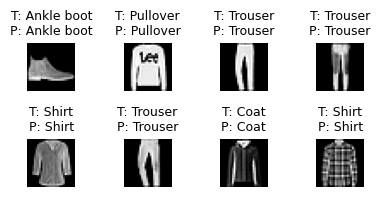

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model.eval()

images, labels = next(iter(test_loader))

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
plt.figure(figsize=(4, 4))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"T: {class_names[labels[i]]}\nP: {class_names[preds[i]]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


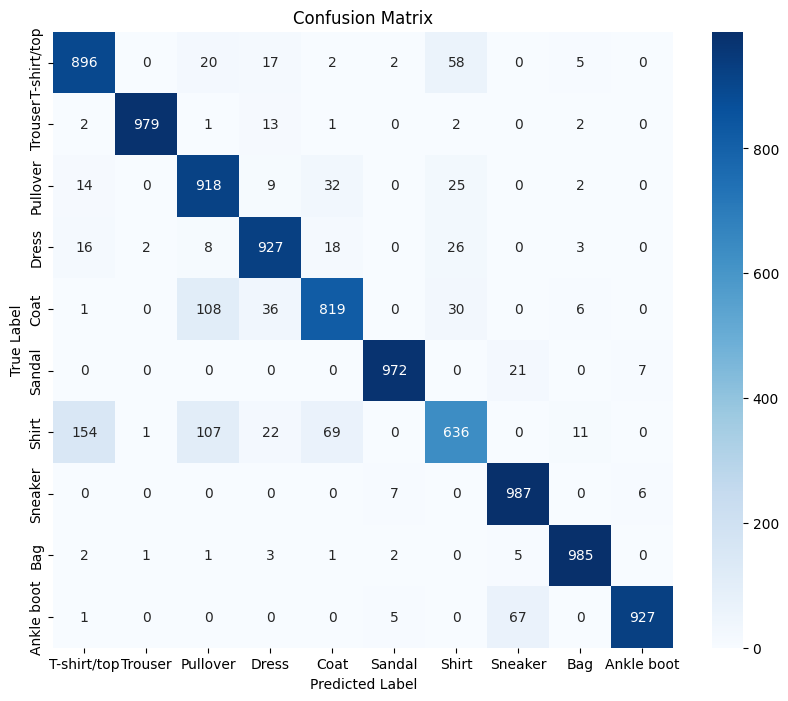

In [21]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
